In [ ]:
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from sklearn.feature_extraction.text import CountVectorizer
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore") 
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Dataset 2/Dataset 2.csv', encoding='latin1')

In [ ]:
class Sequences(Dataset):
    def __init__(self, data):
        self.vectorizer = CountVectorizer(stop_words='english')
        self.sequences = self.vectorizer.fit_transform(data.text.tolist())
        self.labels = data.polarity.tolist()
        self.token2idx = self.vectorizer.vocabulary_
        self.idx2token = {idx: token for token, idx in self.token2idx.items()}
    
    def __getitem__(self, i):
        return self.sequences[i, :].toarray(), self.labels[i]
    
    def __len__(self):
        return self.sequences.shape[0]

In [ ]:
batch_size = 100

dataset = Sequences(df)
train_size = int(len(dataset) * .8);
test_size = int(len(dataset) - train_size);
train_dataset, test_dataset = torch.utils.data.random_split(dataset,[train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [ ]:
input_size = len(dataset.token2idx)
hidden_size = 128
num_classes = 2
num_layers = 3
learning_rate = 0.01
sequence_length = 5
num_epochs = 5

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(self.hidden_size, num_classes)
    
    def forward(self, x):
        # Set initial hidden and cell states 
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

In [ ]:
model = LSTM(input_size, hidden_size, num_layers, num_classes).to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# Train the model
y_pred = []
y_test = []
iter = []
losses = []
itr = 0
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (text, labels) in enumerate(train_loader):
        labels = labels.to(device)
        text = torch.tensor(text, dtype = torch.float)
        # Forward pass
        outputs = model(text)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        itr = itr + 1
        if (i+1) % 20 == 0:
            iter.append(itr)
            losses.append(loss.item())
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
        
# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for text, labels in test_loader:
        labels = labels.to(device)
        text = torch.tensor(text, dtype = torch.float)
        outputs = model(text)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        y_pred.extend(predicted)
        y_test.extend(labels)

    print('Test Accuracy of the model on the 10000 test texts: {} %'.format(100 * correct / total)) 

# Save the model checkpoint
# torch.save(model.state_dict(), 'model.ckpt')

Epoch [1/5], Step [20/83], Loss: 0.0354
Epoch [1/5], Step [40/83], Loss: 0.0120
Epoch [1/5], Step [60/83], Loss: 0.0169
Epoch [1/5], Step [80/83], Loss: 0.0302
Epoch [2/5], Step [20/83], Loss: 0.0010
Epoch [2/5], Step [40/83], Loss: 0.0007
Epoch [2/5], Step [60/83], Loss: 0.0004
Epoch [2/5], Step [80/83], Loss: 0.0009
Epoch [3/5], Step [20/83], Loss: 0.0003
Epoch [3/5], Step [40/83], Loss: 0.0003
Epoch [3/5], Step [60/83], Loss: 0.0003
Epoch [3/5], Step [80/83], Loss: 0.0002
Epoch [4/5], Step [20/83], Loss: 0.0003
Epoch [4/5], Step [40/83], Loss: 0.0003
Epoch [4/5], Step [60/83], Loss: 0.0002
Epoch [4/5], Step [80/83], Loss: 0.0001
Epoch [5/5], Step [20/83], Loss: 0.0003
Epoch [5/5], Step [40/83], Loss: 0.0003
Epoch [5/5], Step [60/83], Loss: 0.0003
Epoch [5/5], Step [80/83], Loss: 0.0001
Test Accuracy of the model on the 10000 test texts: 99.12748424624334 %


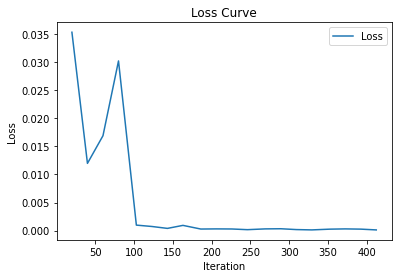

In [ ]:
plt.plot(iter, losses, label='Loss')
plt.title('Loss Curve')
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.legend()

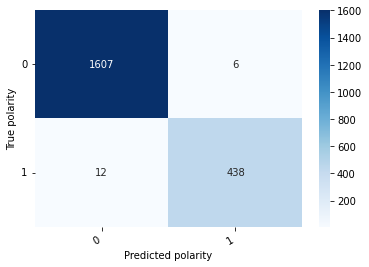

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True polarity')
  plt.xlabel('Predicted polarity');
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=[0,1], columns=[0,1])
show_confusion_matrix(df_cm)


In [ ]:
print('F1 score: ', f1_score(y_test, y_pred, average='binary'))
print('Precision: ', precision_score(y_test, y_pred, average='binary'))
print('Recall: ', recall_score(y_test, y_pred, average='binary'))

F1 score:  0.9798657718120806
Precision:  0.9864864864864865
Recall:  0.9733333333333334
